# Predicting MLB Cy Young Winners

CMSC422 Final Project

Spring 2023 Teli

Clay Miller

# Introduction

The Cy Young Award is an award given to the best pitcher in the American League and National League of Major League Baseball each year. The voting is conducted by the Baseball Writer's Association of America at the end of the regular season each year. The award is named after Hall of Fame pitcher Cy Young who died in 1955, who holds the record for most career MLB wins at 511. For the first 10 years after his death, the award was given to the best pitcher across both leagues. Since 1967, the award has been given to one pitcher in each league every year, with a weighted votes system.

# Motivation

The goal of this project is to create predictive models to determine who should win the Cy Young Award for a season based on the statistics they put up in the season in which they received votes for the award. Since the voting is done by baseball writers for each team ranking players from first to fifth in their voting, the best players in each league end up getting votes but the best may not always win. Therefore, this project sets out to determine which player seasons are worthy of the Cy Young Award that received at least 1 vote, by comparing their season statistics to other award winning seasons. 

These predictions can be used by people involved with baseball, whether it be people betting on who will win the award, people looking for what the best season statistics by pitchers are, or what seasons may not have deserved to win the Cy Young Award. The goal is to see how accurate each model is in predicting what season statistics should win the award that actually won the award.

# Data

Data is imported from https://www.baseball-reference.com/awards/cya.shtml and votingdata.csv contains the pitchers who have received at least 1 vote for the award between the 2000 and 2022 season, put into a dataframe.

An id column is created in order to link the dataframe to a players dataframe containing the player's id, name and ranking to be compared to after running the models. Columns that are not significant or repetitive in determining the award winner for that season are dropped from the table and a CY column is created that is equal to 1 for player seasons that won the award and 0 otherwise.

In [47]:
import requests
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#Reading the data into a data frame
awardvoting = pd.read_csv('votingdata.csv', dtype={'Year' : 'Int64', 'WAR': 'Float64', 'W': 'Int64', 'L': 'Int64', 
                                                   'W-L%': 'Float64', 'ERA': 'Float64', 'G': 'Int64', 'GS': 'Int64', 
                                                   'GF': 'Int64', 'CG': 'Int64', 'SHO': 'Int64', 'SV': 'Int64', 'IP': 'Float64',
                                                   'H': 'Int64', 'R': 'Int64', 'ER': 'Int64', 'HR': 'Int64', 'BB': 'Int64',
                                                   'IBB': 'Int64', 'SO': 'Int64', 'HBP': 'Int64', 'BK': 'Int64', 'WP': 'Int64',
                                                   'BF': 'Int64', 'WHIP': 'Float64', 'ERA+': 'Int64'})
#creating id column
awardvoting['id'] = awardvoting.index

#creating a CY column to predict
awardvoting['CY'] = np.where(awardvoting['Rank'] == 1, 1, 0)

#create players data frame to link ids to player names and ranks
players = awardvoting.filter(['id', 'Name', 'Rank'], axis=1)

#Getting rid of unnecessary columns
awardvoting = awardvoting.drop(columns = ['Tm', 'Rank', 'Vote Pts', '1st Place', 'Share','Name-additional', 'G', 'GS', 
                                          'GF', 'SV', 'H', 'R', 'ER', 'HR', 'BB', 'IBB', 'HBP', 'BK', 'WP'])
awardvoting.head()

,Name,Year,League,WAR,W,L,W-L%,ERA,CG,SHO,IP,SO,BF,WHIP,ERA+,id,CY
0,Justin Verlander,2022,AL,5.7,18,4,0.818,1.75,0,0,175.0,185,666,0.829,223,0,1
1,Dylan Cease,2022,AL,6.4,14,8,0.636,2.2,1,1,184.0,227,747,1.109,184,1,0
2,Alek Manoah,2022,AL,6.0,16,7,0.696,2.24,0,0,196.2,180,786,0.992,170,2,0
3,Shohei Ohtani,2022,AL,6.2,15,9,0.625,2.33,0,0,166.0,219,660,1.012,174,3,0
4,Framber Valdez,2022,AL,3.5,17,6,0.739,2.82,3,1,201.1,194,827,1.157,138,4,0


In [48]:
players.head()

,id,Name,Rank
0,0,Justin Verlander,1
1,1,Dylan Cease,2
2,2,Alek Manoah,3
3,3,Shohei Ohtani,4
4,4,Framber Valdez,5


# Statistics
https://www.mlb.com/glossary/standard-stats
https://www.mlb.com/glossary/advanced-stats

WAR is a statistic that is used to determine how many more wins a player is worth than a replacement level player or just the average player at that position

Win is a statistic given to a pitcher who was pitching when their team takes the lead and holds onto it, a starting pitcher needs to pitch at least five innings to be eligible.

Loss is given to the pitcher who gives up the run that ends up being the difference in the game.

W-L% is the ratio of wins to losses for the pitcher

ERA is earned run average meaning the amount of runs the pitcher allows per nine innings that the pitcher is responsible for.

CG is a complete game meaning the pitcher pitches the game from start to finish.

SHO is a shutout meaning a starting pitcher pitches the entire game for a team and does not give up a run.

IP is the number of innings a pitcher completes in a game.

SO is strikeouts which is when a pitcher gets a batter to get to three strikes to get out.

BF is batters faced which is the amount of batters a pitcher faces in a game.

WHIP is walks and hits per inning pitched which demonstrates how many batters a pitcher allows to get on base in an inning.

ERA+ takes a pitcher's ERA and normalizes it to the entire league accounting for what stadium a pitcher pitches in and the opponents they face.

In [49]:
awardvoting = awardvoting.drop('Name', axis=1)
print(awardvoting.columns)

Index(['Year', 'League', 'WAR', 'W', 'L', 'W-L%', 'ERA', 'CG', 'SHO', 'IP',
       'SO', 'BF', 'WHIP', 'ERA+', 'id', 'CY'],
      dtype='object')


Wins above replacement having a strong correlation with winning the award makes sense as pitchers that bring you the most wins tend to be the most valuable, wins for the same reason, complete games and shutouts are the best things a pitcher can do in a game, the more innings pitched the more valuable, same with batters faced. Win loss percent should also be correlated as good pitchers bring you more wins than losses, ERA+ seems to have a lower correlation than expected.

Losses, ERA and WHIP is better to have lower numbers so it makes sense they have negative correlation

In [50]:
awardvoting.corr()['CY'].sort_values(ascending=False)

CY      1.000000
WAR     0.409292
SO      0.308910
W       0.248715
CG      0.241113
IP      0.209518
SHO     0.199359
BF      0.181163
W-L%    0.172433
id      0.057440
ERA+    0.037398
L      -0.054225
Year   -0.072738
ERA    -0.139616
WHIP   -0.163596
Name: CY, dtype: float64

# Models

Now, models will be used to predict which player seasons should win the Cy Young award by training on Cy young award winners.
SK learn's train test split:https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html is used in order to split the data into training and test sets. A sample of 20% of the data is used as the test set.

In [80]:
from sklearn.model_selection import train_test_split

# Dropping the Cy column the input data
X = awardvoting.drop('CY', axis=1)

#Setting the output to be the CY column which is being predicted
y = awardvoting['CY']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

#Dropping the league and year columns to make sure they do not influence results
X_train = X_train.drop('League', axis=1)
X_test = X_test.drop('League', axis=1)
X_train = X_train.drop('Year', axis=1)
X_test = X_test.drop('Year', axis=1)

# Decision Trees

A decision tree is used by importing scikit learn decsion trees from https://scikit-learn.org/stable/modules/tree.html

[Text(208.64347826086959, 205.35999999999999, 'X[0] <= 7.05\ngini = 0.194\nsamples = 321\nvalue = [286, 35]'),
 Text(140.7130434782609, 181.2, 'X[1] <= 19.5\ngini = 0.097\nsamples = 275\nvalue = [261, 14]'),
 Text(72.78260869565219, 157.04, 'X[12] <= 1.0\ngini = 0.048\nsamples = 242\nvalue = [236, 6]'),
 Text(63.07826086956522, 132.88, 'gini = 0.0\nsamples = 1\nvalue = [0, 1]'),
 Text(82.48695652173913, 132.88, 'X[3] <= 0.814\ngini = 0.041\nsamples = 241\nvalue = [236, 5]'),
 Text(38.81739130434783, 108.72, 'X[10] <= 0.708\ngini = 0.027\nsamples = 219\nvalue = [216, 3]'),
 Text(19.408695652173915, 84.56, 'X[11] <= 355.0\ngini = 0.32\nsamples = 5\nvalue = [4, 1]'),
 Text(9.704347826086957, 60.400000000000006, 'gini = 0.0\nsamples = 1\nvalue = [0, 1]'),
 Text(29.11304347826087, 60.400000000000006, 'gini = 0.0\nsamples = 4\nvalue = [4, 0]'),
 Text(58.22608695652174, 84.56, 'X[8] <= 233.5\ngini = 0.019\nsamples = 214\nvalue = [212, 2]'),
 Text(48.52173913043479, 60.400000000000006, 'gini =

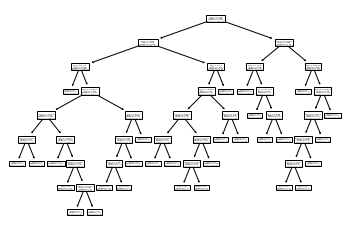

In [86]:
from sklearn import tree
dt = tree.DecisionTreeClassifier()
dt.fit(X_train, y_train)

y_pred = dt.predict(X_test)
dt.score(X_train, y_train)

tree.plot_tree(dt)

An accuracy score from https://scikitlearn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html is used to determine the accuracy of the predictions on the testing set.

In [106]:
#chance a player's season wins the award
pred_proba = dt.predict_proba(X_test)

#combine chance player's season wins an award with dataframe containing the player's name and ranking based on id
cypredictions = []
for i in enumerate(pred_proba):
    cypredictions.append(i[1][1])

cypredictions = np.asarray(cypredictions)
results_CY = pd.DataFrame({'id': X_test['id'], 'CY': cypredictions})

results_CY = players.merge(results_CY, on='id')

#The player seasons in the test set with highest predicted probability of winning the award
results_CY = results_CY.sort_values(by='CY', ascending=False)
print(results_CY.head(12))

#The player seasons in the test set that won the award and their predicted probability according to the model
results_Rank = results_CY.sort_values(by='Rank', ascending=True)
print(results_Rank.head(12))

     id              Name  Rank   CY
0     1       Dylan Cease     2  1.0
72  336  Dontrelle Willis     2  1.0
44  176   Adam Wainwright     3  1.0
37  158   Clayton Kershaw     3  1.0
32  142    Dallas Keuchel     1  1.0
51  225  Justin Verlander     1  1.0
60  283         Cliff Lee     1  1.0
14   52     Liam Hendriks     9  1.0
61  287    Mariano Rivera     5  1.0
43  175      Johnny Cueto     2  1.0
78  396     Randy Johnson     1  1.0
76  379       Mark Mulder     2  1.0
     id              Name  Rank   CY
67  320      Brandon Webb     1  0.0
64  296       CC Sabathia     1  0.0
10   22        Robbie Ray     1  0.0
15   54      Trevor Bauer     1  0.0
32  142    Dallas Keuchel     1  1.0
51  225  Justin Verlander     1  1.0
60  283         Cliff Lee     1  1.0
5    10   Sandy Alcantara     1  0.0
55  236   Clayton Kershaw     1  0.0
20   74      Jacob deGrom     1  0.0
78  396     Randy Johnson     1  1.0
77  385    Curt Schilling     2  0.0


Besides a couple outlying 3rd, 5th and 9th place finishers projected to win, every predicted winner from the test set finished either 1st or 2nd, showing that the decision tree agrees with the voters for the most part.

The accuracy on the training set is determined to be 

In [97]:
print(dt.score(X_train, y_train))

1.0


whereas the accuracy on the test set is determined to be

In [98]:
from sklearn.metrics import accuracy_score
y_true = np.array(y_test)
accuracy_score(y_true, y_pred)

0.8148148148148148

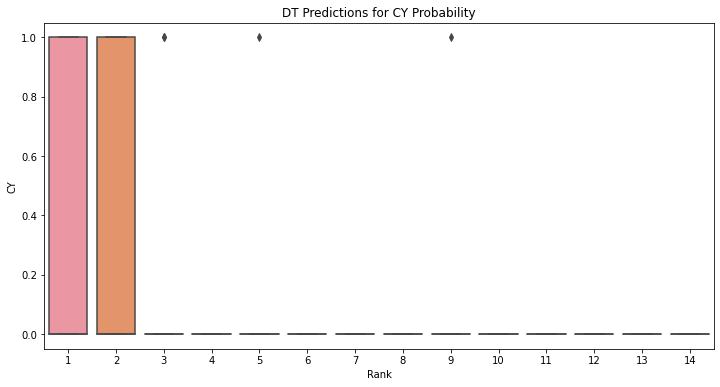

In [107]:
plt.figure(figsize=(12,6))
g = sns.boxplot(x = results_CY.Rank, y = results_CY.CY)
plt.title('DT Predictions for CY Probability')
plt.show()

It is clear that decision trees giving a result of either win the Cy Young award or not when trained on the training data does not give much to take away from in terms of results. The seasons that won the award or finished 2nd are strongly favored by the model because it will end up returning 0 instead of a percent chance of winning the award for those that are unlikely. The accuracy on the test set was fine but it could be improved with a different model as this seems to overfit the training set.

# KNN

A K Nearest Neighbors Classifier is used by importing scikit learn KNeighborsClassifier from
https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html

Finding the best value for K was performed and the best value for k was found to be 13
https://www.datacamp.com/tutorial/k-nearest-neighbor-classification-scikit-learn


Text(0, 0.5, 'Accuracy Score')

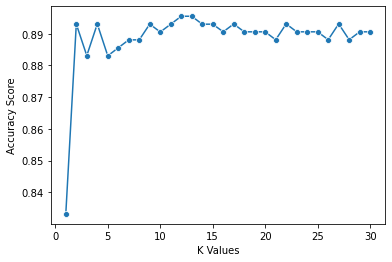

In [242]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

# X = X.drop('League', axis=1)
# X = X.drop('Year', axis=1)

k_values = [i for i in range (1,31)]
scores = []

scaler = StandardScaler()
X = scaler.fit_transform(X)

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    score = cross_val_score(knn, X, y, cv=5)
    scores.append(np.mean(score))

sns.lineplot(x = k_values, y = scores, marker = 'o')
plt.xlabel("K Values")
plt.ylabel("Accuracy Score")

In [243]:
knn = KNeighborsClassifier(n_neighbors=13)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

#chance a player's season wins the award
pred_proba = knn.predict_proba(X_test)

#combine chance player's season wins an award with dataframe containing the player's name and ranking based on id
cypredictions = []
for i in enumerate(pred_proba):
    cypredictions.append(i[1][1])

cypredictions = np.asarray(cypredictions)
results_CY = pd.DataFrame({'id': X_test['id'], 'CY': cypredictions})

results_CY = players.merge(results_CY, on='id')

#The player seasons in the test set with highest predicted probability of winning the award
results_CY = results_CY.sort_values(by='CY', ascending=False)
print(results_CY.head(12))

#The player seasons in the test set that won the award and their predicted probability according to the model
results_Rank = results_CY.sort_values(by='Rank', ascending=True)
print(results_Rank.head(12))

     id               Name  Rank        CY
78  396      Randy Johnson     1  0.461538
77  385     Curt Schilling     2  0.307692
51  225   Justin Verlander     1  0.307692
80  401        Kevin Brown     6  0.230769
29  135  Madison Bumgarner     4  0.230769
37  158    Clayton Kershaw     3  0.230769
41  170        David Price     6  0.230769
43  175       Johnny Cueto     2  0.230769
55  236    Clayton Kershaw     1  0.230769
73  344     Pedro Martinez     4  0.230769
21   76       Max Scherzer     3  0.153846
32  142     Dallas Keuchel     1  0.153846
     id              Name  Rank        CY
78  396     Randy Johnson     1  0.461538
60  283         Cliff Lee     1  0.000000
51  225  Justin Verlander     1  0.307692
5    10   Sandy Alcantara     1  0.000000
10   22        Robbie Ray     1  0.000000
15   54      Trevor Bauer     1  0.076923
55  236   Clayton Kershaw     1  0.230769
67  320      Brandon Webb     1  0.153846
32  142    Dallas Keuchel     1  0.153846
20   74      Jacob de

KNN using the 13 nearest neighbors was able to predict more accurately than decision trees but still could be improved. It mostly predicted the 1st and 2nd place finishers to have the best odds at winning but it did have some outlying lower place vote getters that it gave the same odds to win. For example, it gives the 4th and 6th place finishers better odds than expected.

The accuracy on the training set is determined to be

In [244]:
print(knn.score(X_train, y_train))

0.8909657320872274


whereas the accuracy on the test set is determined to be

In [245]:
accuracy_score(y_true, y_pred)

0.8641975308641975

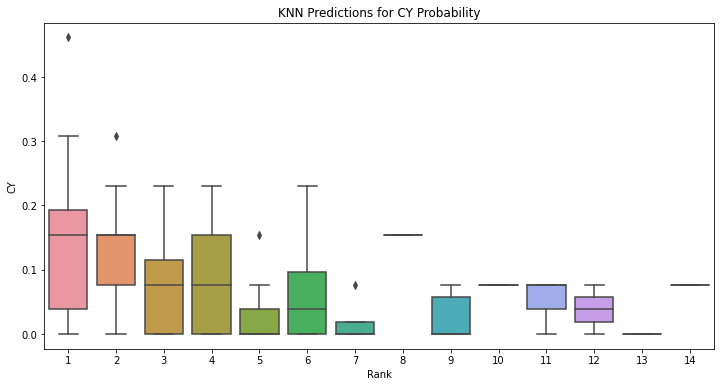

In [246]:
plt.figure(figsize=(12,6))
g = sns.boxplot(x = results_CY.Rank, y = results_CY.CY)
plt.title('KNN Predictions for CY Probability')
plt.show()

It is clear that the KNN model gives non first-place finishers much better odds than decision trees but it is clear improvements can still be made.

# SVM
SVM is used by importing scikit learnSVC from https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

In [247]:
from sklearn.svm import SVC
svm = SVC(kernel='linear', probability=True)
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)

#chance a player's season wins the award
pred_proba = svm.predict_proba(X_test)

#combine chance player's season wins an award with dataframe containing the player's name and ranking based on id
cypredictions = []
for i in enumerate(pred_proba):
    cypredictions.append(i[1][1])

cypredictions = np.asarray(cypredictions)
results_CY = pd.DataFrame({'id': X_test['id'], 'CY': cypredictions})

results_CY = players.merge(results_CY, on='id')

#The player seasons in the test set with highest predicted probability of winning the award
results_CY = results_CY.sort_values(by='CY', ascending=False)
print(results_CY.head(12))

#The player seasons in the test set that won the award and their predicted probability according to the model
results_Rank = results_CY.sort_values(by='Rank', ascending=True)
print(results_Rank.head(12))

     id              Name  Rank        CY
51  225  Justin Verlander     1  0.459346
78  396     Randy Johnson     1  0.440990
55  236   Clayton Kershaw     1  0.390970
77  385    Curt Schilling     2  0.370921
37  158   Clayton Kershaw     3  0.363383
60  283         Cliff Lee     1  0.295461
43  175      Johnny Cueto     2  0.247344
32  142    Dallas Keuchel     1  0.205925
62  294       CC Sabathia     5  0.200688
72  336  Dontrelle Willis     2  0.183630
80  401       Kevin Brown     6  0.174833
44  176   Adam Wainwright     3  0.173200
     id              Name  Rank        CY
51  225  Justin Verlander     1  0.459346
20   74      Jacob deGrom     1  0.108332
5    10   Sandy Alcantara     1  0.113665
10   22        Robbie Ray     1  0.088638
15   54      Trevor Bauer     1  0.061728
64  296       CC Sabathia     1  0.138617
32  142    Dallas Keuchel     1  0.205925
67  320      Brandon Webb     1  0.106295
78  396     Randy Johnson     1  0.440990
60  283         Cliff Lee     1  0

Clearly, SVM performs better than the previous 2 models on the test set and gives the first place finishers much better odds than the rest of the rankings. This shows that this model fits the data better than the other 2 and it is reflected in the test accuracy. It also does not have major outliers like the previous 2 models.

The accuracy on the training set is determined to be

In [248]:
print(svm.score(X_train, y_train))

0.9034267912772586


whereas the accuracy on the test set is determined to be

In [249]:
accuracy_score(y_true, y_pred)

0.8765432098765432

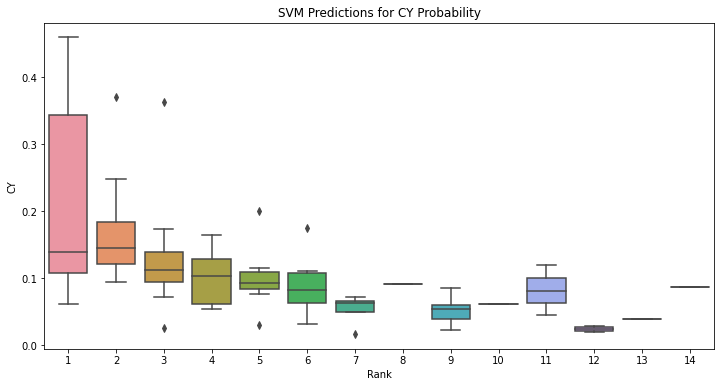

In [250]:
plt.figure(figsize=(12,6))
g = sns.boxplot(x = results_CY.Rank, y = results_CY.CY)
plt.title('SVM Predictions for CY Probability')
plt.show()

# Neural Networks

Finally, Neural Networks are used by importing MLP Classifier from https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html

A confusion matrix was created using https://www.pluralsight.com/guides/machine-learning-neural-networks-scikit-learn


In [294]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import r2_score
from sklearn.neural_network import MLPRegressor

mlp = MLPClassifier(hidden_layer_sizes=(8,8,8), activation='relu', solver='adam', max_iter=310)
mlp.fit(X_train,y_train)

predict_train = mlp.predict(X_train)
predict_test = mlp.predict(X_test)

from sklearn.metrics import classification_report,confusion_matrix
print(confusion_matrix(y_train,predict_train))
print(classification_report(y_train,predict_train))
print(confusion_matrix(y_test,predict_test))
print(classification_report(y_test,predict_test))

[[284   2]
 [ 33   2]]
              precision    recall  f1-score   support

           0       0.90      0.99      0.94       286
           1       0.50      0.06      0.10        35

    accuracy                           0.89       321
   macro avg       0.70      0.53      0.52       321
weighted avg       0.85      0.89      0.85       321

[[70  0]
 [10  1]]
              precision    recall  f1-score   support

           0       0.88      1.00      0.93        70
           1       1.00      0.09      0.17        11

    accuracy                           0.88        81
   macro avg       0.94      0.55      0.55        81
weighted avg       0.89      0.88      0.83        81



In [301]:
y_pred = mlp.predict(X_test)
#chance a player's season wins the award
pred_proba = mlp.predict_proba(X_test)

#combine chance player's season wins an award with dataframe containing the player's name and ranking based on id
cypredictions = []
for i in enumerate(pred_proba):
    cypredictions.append(i[1][1])

cypredictions = np.asarray(cypredictions)
results_CY = pd.DataFrame({'id': X_test['id'], 'CY': cypredictions})

results_CY = players.merge(results_CY, on='id')

#The player seasons in the test set with highest predicted probability of winning the award
results_CY = results_CY.sort_values(by='CY', ascending=False)
print(results_CY.head(12))

#The player seasons in the test set that won the award and their predicted probability according to the model
results_Rank = results_CY.sort_values(by='Rank', ascending=True)
print(results_Rank.head(12))

     id               Name  Rank        CY
78  396      Randy Johnson     1  0.679421
77  385     Curt Schilling     2  0.475857
37  158    Clayton Kershaw     3  0.441913
33  145         Chris Sale     4  0.348875
24  100         Josh Hader     7  0.331890
35  154    Carlos Carrasco    13  0.279662
21   76       Max Scherzer     3  0.264675
55  236    Clayton Kershaw     1  0.254828
73  344     Pedro Martinez     4  0.232815
8    15       Carlos Rodón     6  0.226146
48  200        Matt Harvey     4  0.223663
22   78  Stephen Strasburg     5  0.202812
     id              Name  Rank        CY
78  396     Randy Johnson     1  0.679421
20   74      Jacob deGrom     1  0.187091
15   54      Trevor Bauer     1  0.082570
60  283         Cliff Lee     1  0.063265
51  225  Justin Verlander     1  0.195606
67  320      Brandon Webb     1  0.061098
5    10   Sandy Alcantara     1  0.056757
32  142    Dallas Keuchel     1  0.089070
10   22        Robbie Ray     1  0.165224
64  296       CC Saba

This classifier gets the same level of accuracy on the test set as SVM, while also giving very high predicted probability for the 4th place finisher to win the award as well as having very good odds for a 1st place finisher outlier.

The accuracy on the training set is determined to be

In [302]:
print(mlp.score(X_train, y_train))

0.8909657320872274


whereas the accuracy on the test set is determined to be

In [303]:
accuracy_score(y_true, y_pred)

0.8765432098765432

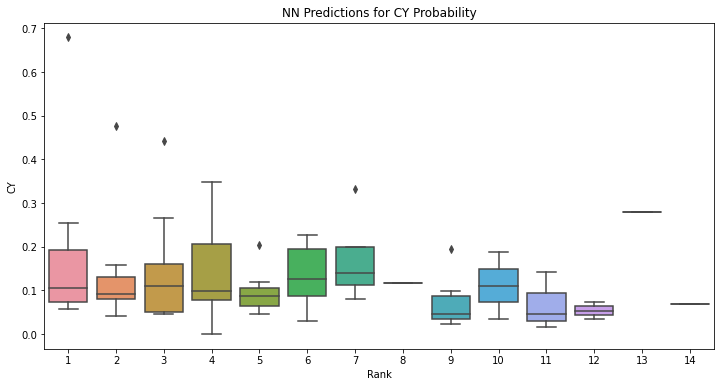

In [304]:
plt.figure(figsize=(12,6))
g = sns.boxplot(x = results_CY.Rank, y = results_CY.CY)
plt.title('NN Predictions for CY Probability')
plt.show()

# Conclusion

SVM and Neural Networks finished the best out of the classifiers on the test set predictions, followed by KNN then Decision Trees performing the worst. All of the models were fairly accurate in predicting whether a player's season would win the Cy Young Award and it is clear some models favor certain statistics from players that finished lower in the test set for the award then others.

# Future Work

Future work would involve expanding the training set to include years further in the past as well as testing on a full season of player statistics to see if the model predicts a player that finished with votes would be predicted to win the award by the models.